# Importing Stuff

In [7]:
import numpy as np
import pandas as pd

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn.preprocessing import Imputer,Normalizer,scale,PolynomialFeatures
from sklearn.model_selection import train_test_split,StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.metrics import recall_score, precision_score,accuracy_score,r2_score

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns

%matplotlib inline
mpl.style.use('ggplot')
sns.set_style('white')
pylab.rcParams[ 'figure.figsize' ] = 8 , 6
!pip install pandas_profiling
import pandas_profiling





# Graph Functions

In [8]:
def plot_histograms( df , variables , n_rows , n_cols ):
    fig = plt.figure( figsize = ( 16 , 12 ) )
    for i, var_name in enumerate( variables ):
        ax=fig.add_subplot( n_rows , n_cols , i+1 )
        df[ var_name ].hist( bins=10 , ax=ax )
        ax.set_title( 'Skew: ' + str( round( float( df[ var_name ].skew() ) , ) ) ) # + ' ' + var_name ) #var_name+" Distribution")
        ax.set_xticklabels( [] , visible=False )
        ax.set_yticklabels( [] , visible=False )
    fig.tight_layout()  # Improves appearance a bit.
    plt.show()

def plot_distribution( df , var , target , **kwargs ):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , hue=target , aspect=4 , row = row , col = col )
    facet.map( sns.kdeplot , var , shade= True )
    facet.set( xlim=( 0 , df[ var ].max() ) )
    facet.add_legend()

def plot_categories( df , cat , target , **kwargs ):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , row = row , col = col )
    facet.map( sns.barplot , cat , target )
    facet.add_legend()

def plot_correlation_map( df ):
    corr = titanic.corr()
    _ , ax = plt.subplots( figsize =( 12 , 10 ) )
    cmap = sns.diverging_palette( 220 , 10 , as_cmap = True )
    _ = sns.heatmap(
        corr, 
        cmap = cmap,
        square=True, 
        cbar_kws={ 'shrink' : .9 }, 
        ax=ax, 
        annot = True, 
        annot_kws = { 'fontsize' : 12 }
    )

def describe_more( df ):
    var = [] ; l = [] ; t = []
    for x in df:
        var.append( x )
        l.append( len( pd.value_counts( df[ x ] ) ) )
        t.append( df[ x ].dtypes )
    levels = pd.DataFrame( { 'Variable' : var , 'Levels' : l , 'Datatype' : t } )
    levels.sort_values( by = 'Levels' , inplace = True )
    return levels

def plot_variable_importance( X , y ):
    tree = DecisionTreeClassifier( random_state = 99 )
    tree.fit( X , y )
    plot_model_var_imp( tree , X , y )
    
def plot_model_var_imp( model , X , y ):
    imp = pd.DataFrame( 
        model.feature_importances_  , 
        columns = [ 'Importance' ] , 
        index = X.columns 
    )
    imp = imp.sort_values( [ 'Importance' ] , ascending = True )
    imp[ : 10 ].plot( kind = 'barh' )
    print (model.score( X , y ))

# Importing Data

In [9]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

full = train.append(test,ignore_index = True,sort = False)

titanic = full[:891]

print('Datasets :', 'full :',full.shape,'titanic :',titanic.shape)

pandas_profiling.ProfileReport(titanic)

Datasets : full : (1309, 12) titanic : (891, 12)


# Analysing Data


C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:715: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:715: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:715: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.wa

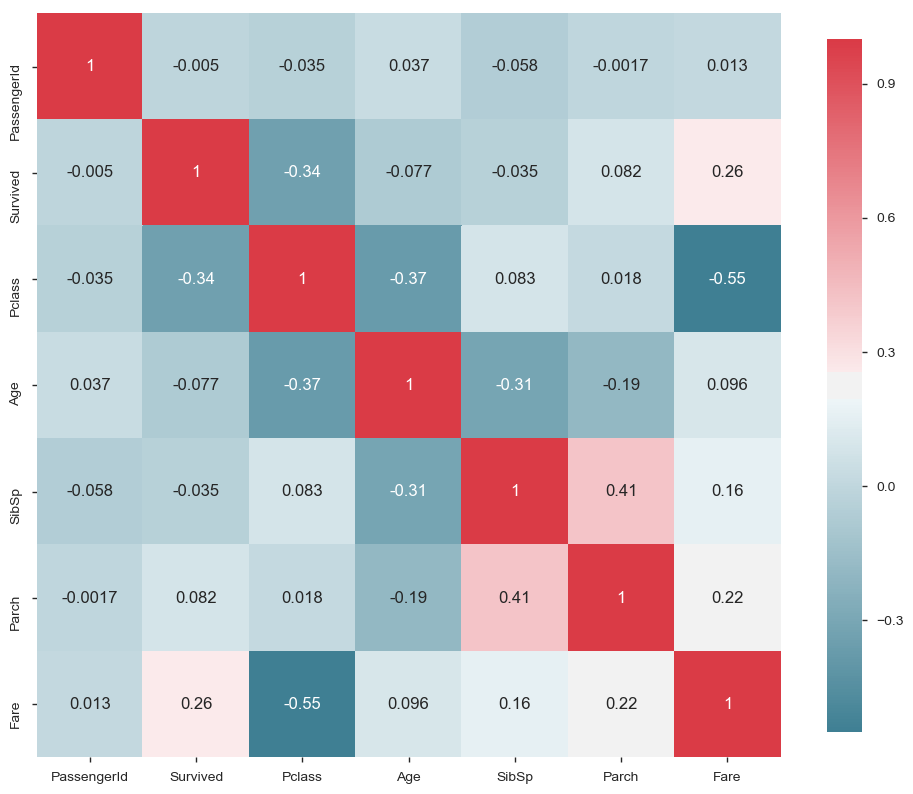

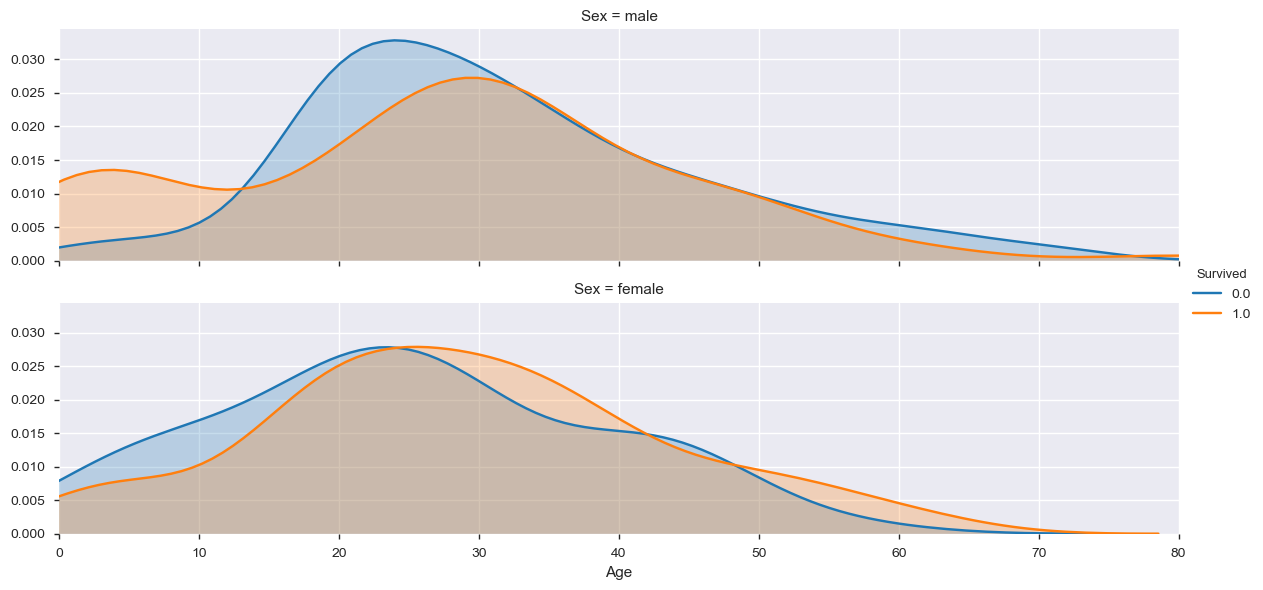

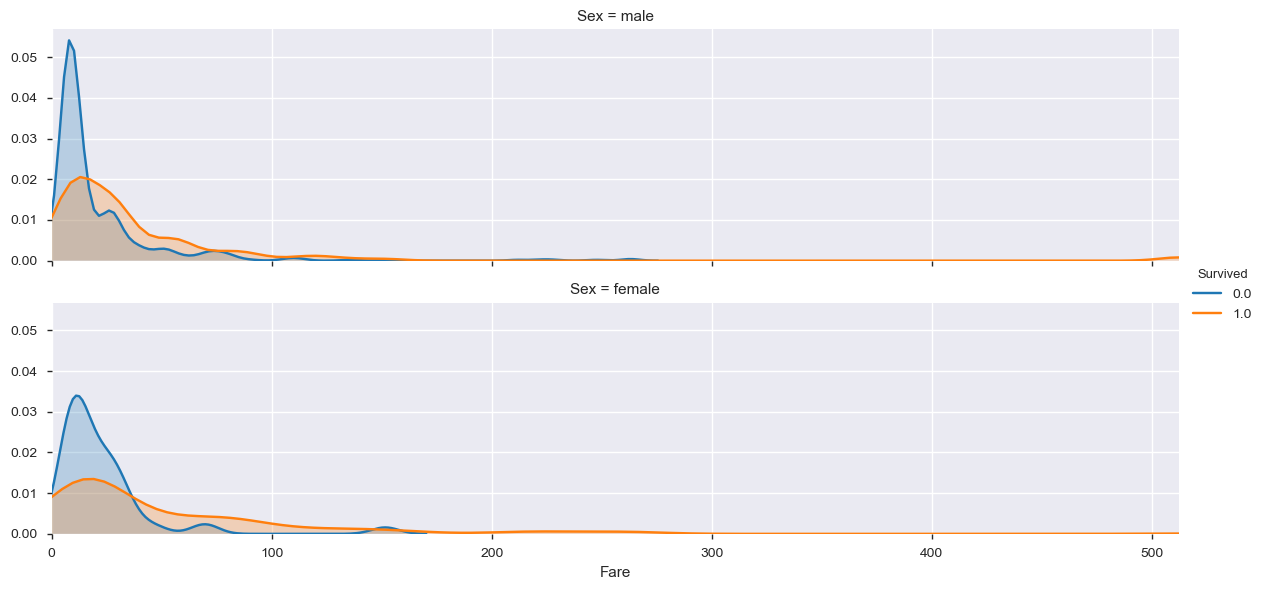

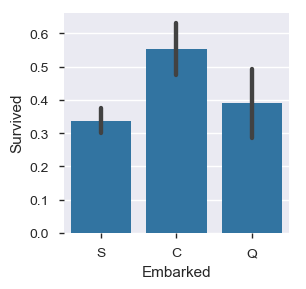

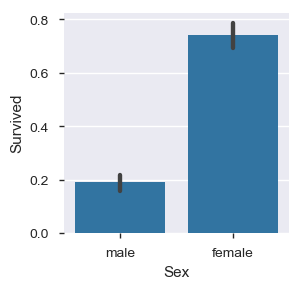

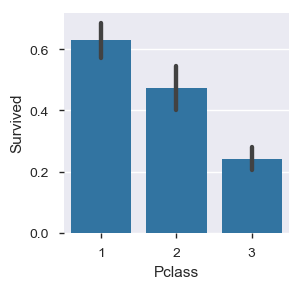

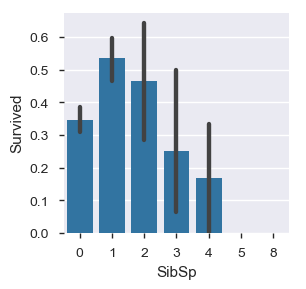

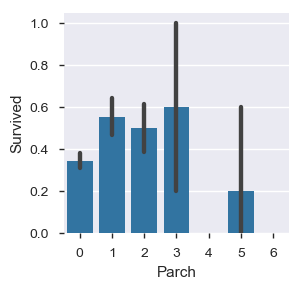

In [10]:
titanic.head()
titanic.describe()
plot_correlation_map(titanic)
plot_distribution(titanic,var ='Age',target='Survived',row = 'Sex')
plot_distribution(titanic,var ='Fare',target='Survived',row = 'Sex')
plot_categories(titanic,cat='Embarked',target='Survived')
plot_categories(titanic,cat='Sex',target='Survived')
plot_categories(titanic,cat='Pclass',target='Survived')
plot_categories(titanic,cat='SibSp',target='Survived')
plot_categories(titanic,cat='Parch',target='Survived')


# Preparing Data

In [11]:
sex = pd.Series(np.where(full.Sex == 'male',1,0),name='Sex')
embarked = pd.get_dummies(full.Embarked,prefix='Embarked')
pclass = pd.get_dummies(full.Pclass,prefix='Pclass')

imputed = pd.DataFrame()
imputed['Age'] = full.Age.fillna(full.Age.mean())
imputed['Fare'] = full.Fare.fillna(full.Fare.mean())

imputed

Age      Fare
0     22.000000    7.2500
1     38.000000   71.2833
2     26.000000    7.9250
3     35.000000   53.1000
4     35.000000    8.0500
5     29.881138    8.4583
6     54.000000   51.8625
7      2.000000   21.0750
8     27.000000   11.1333
9     14.000000   30.0708
10     4.000000   16.7000
11    58.000000   26.5500
12    20.000000    8.0500
13    39.000000   31.2750
14    14.000000    7.8542
15    55.000000   16.0000
16     2.000000   29.1250
17    29.881138   13.0000
18    31.000000   18.0000
19    29.881138    7.2250
20    35.000000   26.0000
21    34.000000   13.0000
22    15.000000    8.0292
23    28.000000   35.5000
24     8.000000   21.0750
25    38.000000   31.3875
26    29.881138    7.2250
27    19.000000  263.0000
28    29.881138    7.8792
29    29.881138    7.8958
...         ...       ...
1279  21.000000    7.7500
1280   6.000000   21.0750
1281  23.000000   93.5000
1282  51.000000   39.4000
1283  13.000000   20.2500
1284  47.000000   10.5000
1285  29.000000   22.0250
1286  18.000000   60.0000
1287  24.000000    7.2500
1288  48.000000   79.2000
1289  22.000000    7.7750
1290  31.000000    7.7333
1291  30.000000  164.8667
1292  38.000000   21.0000
1293  22.000000   59.4000
1294  17.000000   47.1000
1295  43.000000   27.7208
1296  20.000000   13.8625
1297  23.000000   10.5000
1298  50.000000  211.5000
1299  29.881138    7.7208
1300   3.000000   13.7750
1301  29.881138    7.7500
1302  37.000000   90.0000
1303  28.000000    7.7750
1304  29.881138    8.0500
1305  39.000000  108.9000
1306  38.500000    7.2500
1307  29.881138    8.0500
1308  29.881138   22.3583

[1309 rows x 2 columns]

# Feature Eng.

In [12]:
title = pd.DataFrame()
title[ 'Title' ] = full[ 'Name' ].map( lambda name: name.split( ',' )[1].split( '.' )[0].strip() )
Title_Dictionary = {
                    "Capt":       "Officer",
                    "Col":        "Officer",
                    "Major":      "Officer",
                    "Jonkheer":   "Royalty",
                    "Don":        "Royalty",
                    "Sir" :       "Royalty",
                    "Dr":         "Officer",
                    "Rev":        "Officer",
                    "the Countess":"Royalty",
                    "Dona":       "Royalty",
                    "Mme":        "Mrs",
                    "Mlle":       "Miss",
                    "Ms":         "Mrs",
                    "Mr" :        "Mr",
                    "Mrs" :       "Mrs",
                    "Miss" :      "Miss",
                    "Master" :    "Master",
                    "Lady" :      "Royalty"

                    }


title[ 'Title' ] = title.Title.map( Title_Dictionary )
title = pd.get_dummies( title.Title )
#title = pd.concat( [ title , titles_dummies ] , axis = 1 )
title.head()

cabin = pd.DataFrame()
cabin[ 'Cabin' ] = full.Cabin.fillna( 'U' )
cabin[ 'Cabin' ] = cabin[ 'Cabin' ].map( lambda c : c[0] )
cabin = pd.get_dummies( cabin['Cabin'] , prefix = 'Cabin' )
cabin.head()

def cleanTicket( ticket ):
    ticket = ticket.replace( '.' , '' )
    ticket = ticket.replace( '/' , '' )
    ticket = ticket.split()
    ticket = map( lambda t : t.strip() , ticket )
    ticket = list(filter( lambda t : not t.isdigit() , ticket ))
    if len( ticket ) > 0:
        return ticket[0]
    else: 
        return 'XXX'
ticket = pd.DataFrame()
ticket[ 'Ticket' ] = full[ 'Ticket' ].map( cleanTicket )
ticket = pd.get_dummies( ticket[ 'Ticket' ] , prefix = 'Ticket' )
ticket.head()

family = pd.DataFrame()
family[ 'FamilySize' ] = full[ 'Parch' ] + full[ 'SibSp' ] + 1
family[ 'Family_Single' ] = family[ 'FamilySize' ].map( lambda s : 1 if s == 1 else 0 )
family[ 'Family_Small' ]  = family[ 'FamilySize' ].map( lambda s : 1 if 2 <= s <= 4 else 0 )
family[ 'Family_Large' ]  = family[ 'FamilySize' ].map( lambda s : 1 if 5 <= s else 0 )
family.head()
ticket.head()


Ticket_A  Ticket_A4  Ticket_A5  Ticket_AQ3  Ticket_AQ4  Ticket_AS  \
0         0          0          1           0           0          0   
1         0          0          0           0           0          0   
2         0          0          0           0           0          0   
3         0          0          0           0           0          0   
4         0          0          0           0           0          0   

   Ticket_C  Ticket_CA  Ticket_CASOTON  Ticket_FC     ...      Ticket_SOTONO2  \
0         0          0               0          0     ...                   0   
1         0          0               0          0     ...                   0   
2         0          0               0          0     ...                   0   
3         0          0               0          0     ...                   0   
4         0          0               0          0     ...                   0   

   Ticket_SOTONOQ  Ticket_SP  Ticket_STONO  Ticket_STONO2  Ticket_STONOQ  \
0               0          0             0              0              0   
1               0          0             0              0              0   
2               0          0             0              1              0   
3               0          0             0              0              0   
4               0          0             0              0              0   

   Ticket_SWPP  Ticket_WC  Ticket_WEP  Ticket_XXX  
0            0          0           0           0  
1            0          0           0           0  
2            0          0           0           0  
3            0          0           0           1  
4            0          0           0           1  

[5 rows x 37 columns]

# Feature Selection

In [13]:


full_X = pd.concat( [ imputed , embarked ,pclass, family , sex ] , axis=1 )
full_X.head()

train_valid_X = full_X[:891]
train_valid_y = titanic.Survived

train_X,test_X,train_y,test_y = train_test_split(train_valid_X,train_valid_y)
print (full_X.shape , train_X.shape , test_X.shape , train_y.shape , test_y.shape , test_X.shape)

(1309, 13) (668, 13) (223, 13) (668,) (223,) (223, 13)


# Feature Importance

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


0.8293413173652695
0.907185628742515
0.9850299401197605
1 0.8158682634730539
2 0.8368263473053892
3 0.8293413173652695
4 0.8652694610778443
5 0.907185628742515
6 0.781437125748503
7 0.9850299401197605


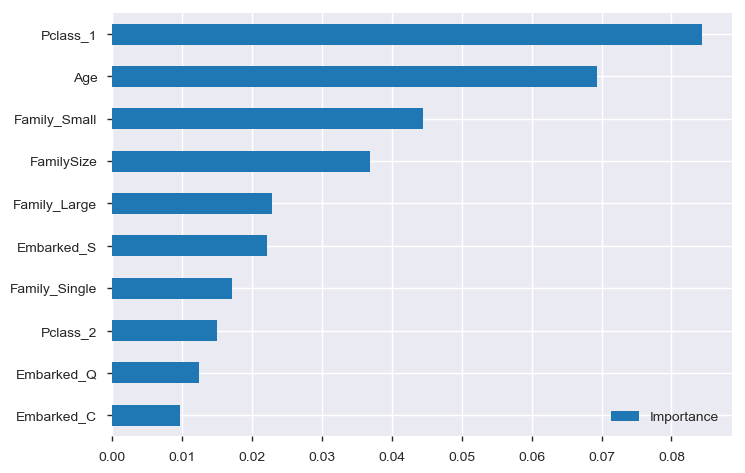

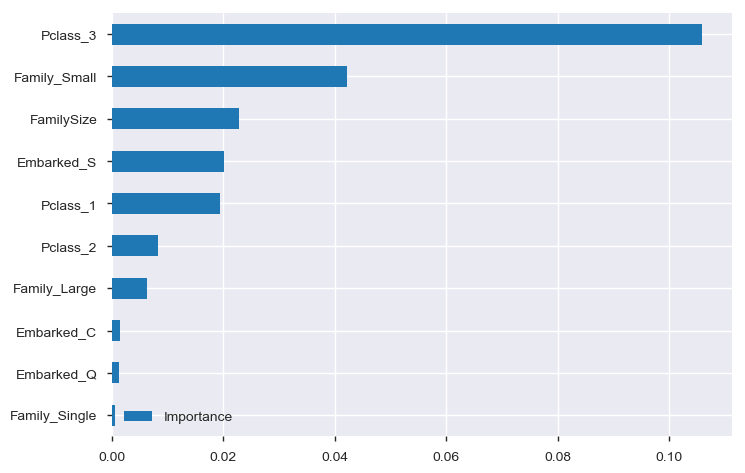

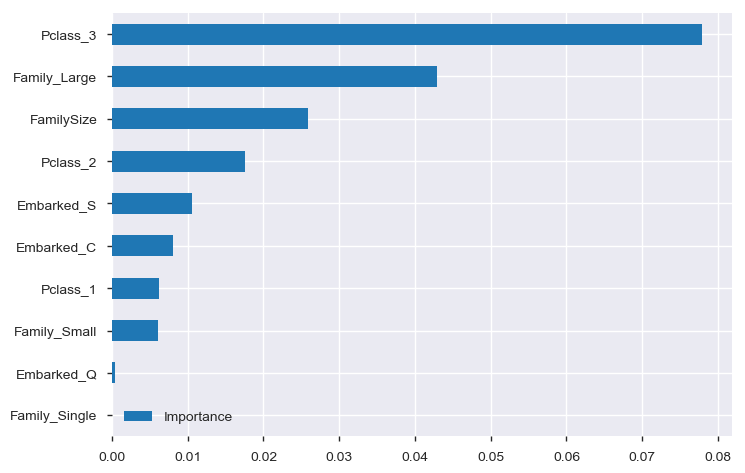

In [24]:
model1 = LogisticRegression()
model2 = KNeighborsClassifier(n_neighbors = 3)
#model3 = PolynomialFeatures(3)
model3 = RandomForestClassifier(n_estimators=100,max_depth = 3,n_jobs = -1)
model4 = SVC()
model5 = GradientBoostingClassifier(learning_rate = 0.1, max_depth = 3)
model6 = GaussianNB()
model7 = DecisionTreeClassifier()

model1.fit(train_X,train_y)
model2.fit(train_X,train_y)
model3.fit(train_X,train_y)
model4.fit(train_X,train_y)
model5.fit(train_X,train_y)
model6.fit(train_X,train_y)
model7.fit(train_X,train_y)

plot_model_var_imp(model3,train_X,train_y)
plot_model_var_imp(model5,train_X,train_y)
plot_model_var_imp(model7,train_X,train_y)

print('1',model1.score(train_X,train_y))
print('2',model2.score(train_X,train_y))
print('3',model3.score(train_X,train_y))
print('4',model4.score(train_X,train_y))
print('5',model5.score(train_X,train_y))
print('6',model6.score(train_X,train_y))
print('7',model7.score(train_X,train_y))



In [25]:
pred1 = model1.predict(test_X)
pred2 = model2.predict(test_X)
pred3 = model3.predict(test_X)
pred4 = model4.predict(test_X)
pred5 = model5.predict(test_X)
pred6 = model6.predict(test_X)
pred7 = model7.predict(test_X)

print('1', accuracy_score(test_y,pred1),recall_score(test_y,pred1),precision_score(test_y,pred1),r2_score(test_y,pred1))
print('2', accuracy_score(test_y,pred2),recall_score(test_y,pred2),precision_score(test_y,pred2),r2_score(test_y,pred2))
print('3', accuracy_score(test_y,pred3),recall_score(test_y,pred3),precision_score(test_y,pred3),r2_score(test_y,pred3))
print('4', accuracy_score(test_y,pred4),recall_score(test_y,pred4),precision_score(test_y,pred4),r2_score(test_y,pred4))
print('5', accuracy_score(test_y,pred5),recall_score(test_y,pred5),precision_score(test_y,pred5),r2_score(test_y,pred5))
print('6', accuracy_score(test_y,pred6),recall_score(test_y,pred6),precision_score(test_y,pred6),r2_score(test_y,pred6))
print('7', accuracy_score(test_y,pred7),recall_score(test_y,pred7),precision_score(test_y,pred7),r2_score(test_y,pred7))

1 0.8251121076233184 0.7586206896551724 0.7857142857142857 0.26495943204868155
2 0.7085201793721974 0.5632183908045977 0.6447368421052632 -0.22506761325219737
3 0.820627802690583 0.6551724137931034 0.8507462686567164 0.2461122379986478
4 0.6771300448430493 0.4482758620689655 0.6190476190476191 -0.35699797160243407
5 0.8385650224215246 0.7586206896551724 0.8148148148148148 0.32150101419878296
6 0.8026905829596412 0.7931034482758621 0.7263157894736842 0.1707234617985125
7 0.7219730941704036 0.6551724137931034 0.6404494382022472 -0.16852603110209596


0.905688622754491 0.852017937219731
Optimal number of features :  7


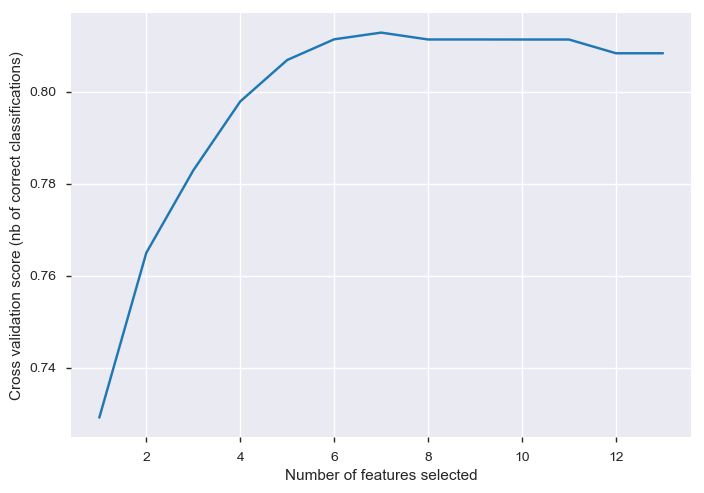

In [26]:
rfecv = RFECV( estimator = model5 , step = 1 , cv = StratifiedKFold( 2 ) , scoring='accuracy')
rfecv.fit( train_X , train_y )

print (rfecv.score( train_X , train_y ) , rfecv.score( test_X , test_y ))
print( "Optimal number of features : " , rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel( "Number of features selected" )
plt.ylabel( "Cross validation score (nb of correct classifications)" )
plt.plot( range( 1 , len( rfecv.grid_scores_ ) + 1 ) , rfecv.grid_scores_ )
plt.show()

In [27]:
valid_X = full_X[ 891: ]
valid_Y = model5.predict( valid_X ).astype(int)
passenger_id = full[891:].PassengerId
test = pd.DataFrame( { 'PassengerId': passenger_id , 'Survived': valid_Y })

test.shape
test
test.to_csv( 'titanic_pred.csv' , index = False)
tt = pd.read_csv('titanic_pred.csv')
tt

PassengerId  Survived
0            892         0
1            893         0
2            894         0
3            895         0
4            896         0
5            897         0
6            898         0
7            899         0
8            900         1
9            901         0
10           902         0
11           903         0
12           904         1
13           905         0
14           906         1
15           907         1
16           908         0
17           909         0
18           910         1
19           911         1
20           912         0
21           913         1
22           914         1
23           915         0
24           916         1
25           917         0
26           918         1
27           919         0
28           920         1
29           921         0
..           ...       ...
388         1280         0
389         1281         0
390         1282         0
391         1283         1
392         1284         1
393         1285         0
394         1286         0
395         1287         1
396         1288         0
397         1289         1
398         1290         0
399         1291         0
400         1292         1
401         1293         0
402         1294         1
403         1295         0
404         1296         0
405         1297         0
406         1298         0
407         1299         0
408         1300         0
409         1301         1
410         1302         1
411         1303         1
412         1304         1
413         1305         0
414         1306         1
415         1307         0
416         1308         0
417         1309         0

[418 rows x 2 columns]